# Reanalyzing Brewster and Franz data 

In [320]:
import numpy as np
import matplotlib.pyplot as plt
import pboc.plotting
import sys
sys.path.insert(0, '../../../')
import mwc_growth as mwc
import tqdm
import pandas as pd
import matlab.engine as matlab
import scipy.optimize
import glob
import seaborn as sns
eng = matlab.start_matlab()
colors = pboc.plotting.set_plotting_style()
%matplotlib inline

## Calculating the calibration factor.

In [391]:

def cell_to_dict(file, eng, add_props=None, excluded_props=None):
    """
    Reads a single cell file and produces a dictionary containing
    the properties of interest.

    The returned properties are
    * birth - frame number at which the cell was born.
    * death - frame number at which the cell died.
    * divide - bool for an observed cell division.
    * ID - integer ID number of the cell.
    * motherID - integer ID number of the mother cell.
    * sisterID - integer ID number of the sister cell.
    * birth_fluo - fluorescence value at the cell's birth.
    * death_fluo - fluorescence value at the cell's death.
    * daughter_1_ID - integer ID number of the first daughter.
    * daughter_2_ID - integer ID number of the second daughter.


    Parameters
    ----------
    file: str
        Path of the cell file. This must be in a `.mat` format.
    eng: MATLAB engine object
        Engine of running matlab session.
    add_props : dict, default None
        Dictionary of additional properties (not found in the mat file)
        to be included in the returned dictionary.
    excluded_props: list of str
        Properties of cell.mat file to be ignored. These must be
        exactly how they are defined in the cell file.

    Returns
    -------
    cell_dict : dictionary
        Dictionary of all extracted properties from the cell files.
    """

    # Ensure the supplied file is actually a .mat and other types are correct.
    if file.split('.')[-1] != 'mat':
        raise TypeError("supplied file {0} is not a `.mat` file.".format(file))
    if add_props is not None and type(add_props) is not dict:
        raise TypeError(
            "add_props is {0} and not dict.".format(type(add_props)))
    if excluded_props is not None and type(excluded_props) is not list:
        raise TypeError(
            "add_props must be list. Type is currently {0}.".format(type(excluded_props)))

    # Define the values of interest.
    vals = ['birth', 'death', 'divide', 'ID', 'motherID', 'sisterID',
            'daughter_1_ID', 'daughter_2_ID', 'birth_fluo', 'death_fluo', 'birth_area', 'death_area']

    # Load the mat file using MATLAB.
    eng.workspace['f'] = file
    mat = eng.eval('load(f)')

    # Assemble the dictionary for constant properties.
    cell_dict = {v: mat[v] for v in vals[:-6]}
    daughters = np.array(mat['daughterID'])

    # Determine  if daughters were produced. If not, change ID to NaN.
    if len(daughters) == 0:
        daughter_1, daughter_2 = None,  None
    else:
        daughter_1, daughter_2 = daughters[0]
    cell_dict['daughter_1_ID'] = daughter_1
    cell_dict['daughter_2_ID'] = daughter_2

    # Extract fluorescence information -- This is a bit gross but checked.
    # Get number of fluorescence channels.
    fluo_channels = [f for f in mat['CellA'][0].keys() if 'fl' in f]
    n_channels = int(len(fluo_channels) / 3)
    for n in range(n_channels):
        _n = n + 1
        fluo = [mat['CellA'][i]['fl{0}'.format(_n)]['sum'] for i, _ in enumerate(mat['CellA'])]
        if np.max(np.array(fluo)) != 0:
            intensity = True 
        else: 
            intensity = False
        cell_dict['fluor{0}'.format(_n)] = np.array(fluo)
        cell_dict['fluor{0}_measured'.format(_n)] = intensity
#         try:
#             fluo = [mat['CellA'][i]['fl{0}'.format(
#                 _n)]['sum'] for i, _ in enumerate(mat['CellA'])]
        bg = [mat['CellA'][i]['fl{0}'.format(_n)]['bg'] for i, _ in enumerate(mat['CellA'])]
#             nonzero = np.where(np.array(fluo) > 0)[0]
#             num_exposures = len(nonzero)
        cell_dict['fluor{0}_bg_birth_fluo'.format(_n)] = np.mean(bg)
        cell_dict['fluor{0}_bg_death_fluo'.format(_n)] = np.mean(bg)
#         cell_dict['fluor{0}_birth_fluo'.format(_n)] = np.mean(fluo)
#         cell_dict['fluor{0}_death_fluo'.format(_n)] = np.mean(fluo)
#             cell_dict['birth_area'] = mat['CellA'][nonzero.min()]['coord']['A']
#             cell_dict['death_area'] = mat['CellA'][nonzero.max()]['coord']['A']
#         except:
#             cell_dict['fluor{0}_birth_fluo'.format(_n)] = 0
#             cell_dict['fluor{0}_death_fluo'.format(_n)] = 0
        cell_dict['birth_area'] = mat['CellA'][0]['coord']['A']
        cell_dict['death_area'] = mat['CellA'][-1]['coord']['A']
#             cell_dict['fluor{0}_bg_birth_fluo'.format(_n)] = 0
#             cell_dict['fluor{0}_bg_death_fluo'.format(_n)] = 0
#             num_exposures = 0
#             cell_dict['fluor{0}_num_exposures'.format(_n)] = num_exposures

    # Deal with exclusion and addition of props.
    if excluded_props is not None:
        new_dict = {}
        keys = cell_dict.keys()
        for key in keys:
            if key not in excluded_props:
                new_dict[key] = cell_dict[key]
        cell_dict = new_dict
    if add_props is not None:
        for key in add_props.keys():
            cell_dict[key] = add_props[key]

    # Return the cell dictionary.
    return cell_dict


def parse_cell_files(files, eng, verbose=False, **kwargs):
    """
    Executes cell_to_dict across a list of files and returns a Pandas DataFrame.
    """
    if type(files) is not list:
        raise TypeError("'files' is type {0} not list.".format(type(files)))
    if verbose:
        files = tqdm.tqdm(files)
    for i, f in enumerate(files):
        cell_dict = cell_to_dict(f, eng, **kwargs)
        if i == 0:
            keys = cell_dict.keys()
            df = pd.DataFrame([], columns=keys)
            df = df.append(cell_dict, ignore_index=True)
        else:
            df = df.append(cell_dict, ignore_index=True)
    return df



def deterministic_log_posterior(alpha, I_1, I_2, I_tot, neg=True):
    """
    Computes the log posterior of the deterministic solution to the estimation of the 
    calibration factor value.
    
    Parameters
    ----------
    alpha : float 
        The value of the calibration factor.
    I_1, I_2, I_tot : 1d-arrays or Pandas Series
        The intensity measurements of the daughter cells and the mother cell for a series of division events.
    neg : bool
        If True, the negative log posterior is returned. Default is True.
    
    Returns
    -------
    lp : float
        Value of the log posterior evaluated at the given value of alpha.
    """
    
    # Ensure that the intensity values are not negative.
    if (I_1 < 0).any() or (I_2 < 0).any():
        return -np.inf
    
    # Ensure that alpha is positive.
    if alpha < 0:
        return -np.inf
    
    # Compute the binomial coefficient.
    n_1 = I_1 / alpha
    n_2 = I_2 / alpha
    n_tot = I_tot / alpha
    binom = scipy.special.gammaln(n_tot+1).sum() - scipy.special.gammaln(n_1+1).sum() -\
            scipy.special.gammaln(n_2+1).sum()
 
    # Compute the log posterior.
    lp = -len(I_1) * np.log(alpha) + binom - n_tot.sum() * np.log(2)
    
    # Determine if the negative log posterior should be returned.
    if neg is True:
        prefactor = -1
    else: 
        prefactor = 1
        
    return prefactor * lp

In [392]:
# Define the data directory.
data_dir = '../../../data/images/20121115_37C_glucose_O1_dilution/'

# Grab the growth positions.
growth_pos = glob.glob('{0}20121115_growth*/xy*'.format(data_dir))

# Set up a list to store the resultant dataframes
dfs = []

# iterate through each position and load the cell files into python.
for i, pos in enumerate(growth_pos):
    
    # Load the cell files.
    cell_files = glob.glob('{0}/cell/*ell*.mat'.format(pos))
    
    # Parse each cell file and get a resulting dataframe.
    position = int(pos.split('/')[-1].split('xy')[1])
    _df = parse_cell_files(cell_files, eng=eng, add_props=dict(position=position),
                           verbose=False)
   
    # Append to the storage list.
    dfs.append(_df)
    
# Concatenate into a single data frame.
growth_df = pd.concat(dfs, ignore_index=True)

In [393]:
# Load the other data sets.
other_sets = glob.glob('{0}*autofluorescence*'.format(data_dir))
desired_props = ['fluor1_birth_fluo', 'fluo2_birth_fluo', 'birth_area']
dfs = []
for i, samp in enumerate(other_sets):
        # Get all of the positions in each folder.
        positions = glob.glob('{0}/xy*/'.format(samp))
    
        # Loop through each position.
        for j, pos in enumerate(positions):
            # Get a list of all cell files.
            cell_files = glob.glob('{0}/cell/*ell*.mat'.format(pos))
        
            # Parse them and exclude properties
            _df = parse_cell_files(cell_files, eng=eng, add_props=dict(position=j, strain='auto'),
                                   verbose=False)
            dfs.append(_df)
         
snap_df = pd.concat(dfs, ignore_index=True)

In [394]:
mean_auto_yfp = np.mean([snap_df['fluor1'][i][0] / snap_df['birth_area'].values for i in range(len(snap_df))])
mean_auto_cherry = np.mean([snap_df['fluor2'][i][0] / snap_df['birth_area']. values for i in range(len(snap_df))])

In [400]:
# Find the max frame.
max_frame = np.sort(growth_df['death'].unique())[-1]
measured = growth_df[(growth_df['fluor2_measured']==True)]

# Set the storage vectors.
I_1, I_2, summed, sq_diff = [], [], [], []

# Group the data by mother ID
grouped = measured.groupby(['position', 'motherID'])
for g, d in grouped:
    if len(d) == 2: 
        daughters = np.array([d.iloc[0]['fluor2'].max(), d.iloc[1]['fluor2'].max()]) - (mean_auto_cherry * d['birth_area'].values)
        if (daughters >= 0).all():
            I_1.append(daughters[0])
            I_2.append(daughters[1])
            summed.append(daughters.sum())
            sq_diff.append((daughters[0] - daughters[1])**2)

I_1 = np.array(I_1)
I_2 = np.array(I_2)
I_tot = I_1 + I_2

ratios = []
for i, j in zip(I_1, I_2):
    ratios.append(np.abs(i / (i + j)))
print(np.mean(ratios)) 


0.49963582865


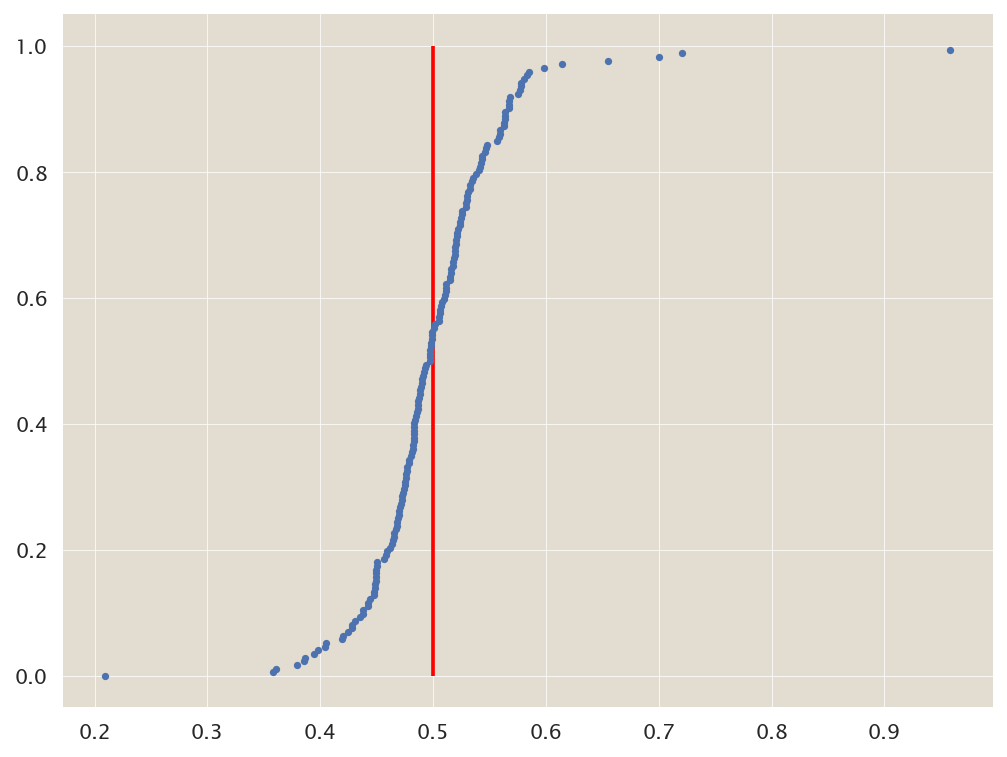

In [401]:
x, y = np.sort(ratios), np.arange(len(ratios)) / len(ratios)
plt.vlines(np.mean(ratios), 0, 1.0, 'r')
plt.plot(x,y, '.')

In [403]:
bgs = growth_df[growth_df['fluor2_measured']==True]['fluor2_bg_birth_fluo'].unique()
print(np.var(bgs) / np.mean(bgs))

0.127965503334


In [409]:
x = I2/ (I1 + I2)


0.15691420464854919

In [387]:
growth_df.keys()[nonzero.max()]

Index(['birth', 'death', 'divide', 'ID', 'motherID', 'sisterID',
       'daughter_1_ID', 'daughter_2_ID', 'fluor1', 'fluor1_measured',
       'fluor1_birth_fluo', 'fluor1_death_fluo', 'birth_area', 'death_area',
       'fluor2', 'fluor2_measured', 'fluor2_birth_fluo', 'fluor2_death_fluo',
       'position'],
      dtype='object')

In [330]:
import pymc3 as pm
import theano.tensor as tt
import pboc.mcmc


In [331]:
import imp
imp.reload(pboc.mcmc)

<module 'pboc.mcmc' from '/Users/gchure/Lab/PhillipsLab201401-XXX/lab_code/pboc-py/pboc/mcmc.py'>

In [332]:
class DeterministicLogPosterior(pm.Continuous):
    def __init__(self, I_1=None, I_2=None, *args, **kwargs):
        super(DeterministicLogPosterior, self).__init__(*args, **kwargs)
    def logp(self, value, *args):
        n1 = I_1 / value
        n2 = I_2 / value
        ntot = n1 + n2
        k = len(I_1)
        binom = tt.sum(tt.gammaln(ntot+1)) - tt.sum(tt.gammaln(n1+1)) -tt.sum(tt.gammaln(n2+1))
        return -k * tt.log(value) + binom - tt.sum(ntot) * tt.log(2)

In [359]:
with pm.Model() as model:
    alpha = DeterministicLogPosterior('alpha', I1, I2, testval=100)
    trace = pm.sample(tune=5000, draws=5000, njobs=4)
    trace_df = pboc.mcmc.trace_to_dataframe(trace, model)
    stats = pboc.mcmc.compute_statistics(trace_df)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
INFO:pymc3:NUTS: [alpha]
100%|██████████| 10000/10000 [00:04<00:00, 2011.98it/s]
The acceptance probability does not match the target. It is 0.714292940004, but should be close to 0.8. Try to increase the number of tuning steps.


In [360]:
alpha_opt = stats['mode'].values[0]
print(alpha_opt)

402.725565079


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a78b8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c234d2908>]], dtype=object)

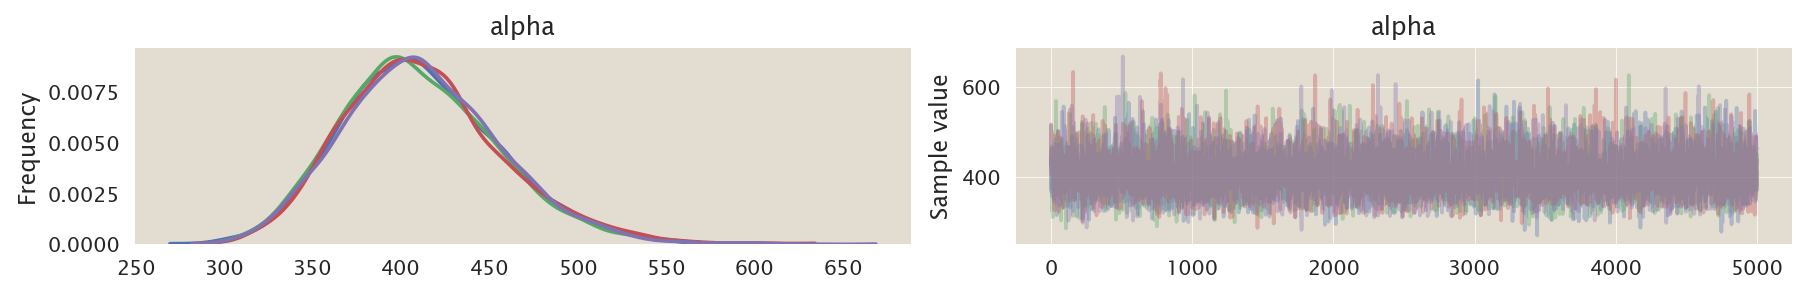

In [361]:
pm.traceplot(trace)

In [336]:
# Bin the data for plotting.
def binning_mean(data, bin_width, sort_values=False):
    """
    Computes the mean value of squared difference and summed intensity of the 
    supplied data with a given number of events per bin. 
    
    Parameters
    ----------
    data : pandas DataFrame
        A dataframe containing the intensities of the daughter cells and the sum
        total intensity.
    bin_width : int
        Number of events to consider per bin.
    sort_values : bool
        If True, the supplied data will be sorted in increasing order of the 
        sum total fluorescence. Default is False.
        
    Returns
    -------
    mean_sq_diff, mean_sum : 1d-arrays
        Arrays of the mean square difference value and the mean summed intensity 
        in a given bin width.  
    """
    # Sort the data if necessary.
    if sort_values:
        data = data.sort_values(by='I_tot')
        
    # Set the bins. 
    bins = np.arange(0, len(data) + bin_width, bin_width)
    
    # Compute the means. 
    mean_sq_diff = [np.mean((data.iloc[bins[i-1]:bins[i]+1]['I_1'] -\
                         data.iloc[bins[i-1]:bins[i]+1]['I_2'])**2) for i in range(1, len(bins))]
    mean_I_tot = [data.iloc[bins[i-1]:bins[i]+1]['I_tot'].mean() for i in range(1, len(bins))] 
    return [np.array(mean_sq_diff), np.array(mean_I_tot)] 

In [342]:
# Set up the data frame.
binning_df = pd.DataFrame(np.array([I_1, I_2, I_tot]).T, columns=['I_1', 'I_2', 'I_tot'])

# Bin the data. 
bin_size =  25
mean_sq_diff, mean_I_tot = binning_mean(binning_df, bin_width=bin_size, sort_values=True)

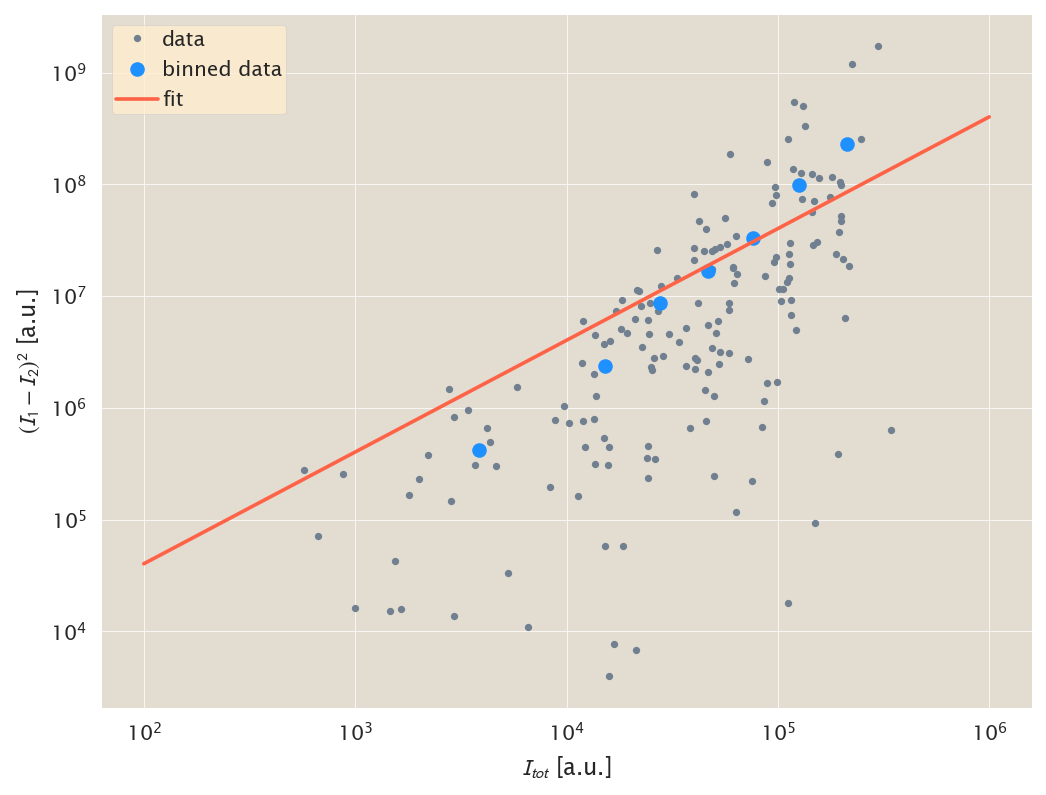

In [343]:
# Make the scatter plot.
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_{tot}$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')

# Plot the data
_ = ax.plot(summed, sq_diff, '.', color='slategray', label='data')

# Plot the binned data.
_ = ax.plot(mean_I_tot, mean_sq_diff, 'o', color='dodgerblue', label='binned data')

# Plot the theory curve. 

I_tot_range = np.logspace(2,6, 500)
theo = alpha_opt* I_tot_range
_ = ax.plot(I_tot_range, theo, '-', color='tomato', label='fit')

_ = ax.legend()

## Testing the calibration factor. 

In [348]:
eng.workspace['f'] = '/Users/gchure/Desktop/dilution_data.mat'
mat = eng.eval('load(f)')

In [366]:
dif = mat['rdif']
tot = mat['rtot']
I2 = (tot - np.sqrt(dif)) / 2
I1 = np.sqrt(dif) + I2
I1 = I1[0]
I2 = I2[0]
# popt = scipy.optimize.minimize_scalar(deterministic_log_posterior, args=(I1, I2, I1+I2, True))
brewster_df = pd.DataFrame(np.array([I1, I2, I1+I2]).T, columns=['I_1', 'I_2', 'I_tot'])

In [350]:
with pm.Model() as model:
    alpha = DeterministicLogPosterior('alpha', I1, I2, testval=100)
    trace = pm.sample(tune=5000, draws=5000, njobs=4)
    trace_df = pboc.mcmc.trace_to_dataframe(trace, model)
    stats = pboc.mcmc.compute_statistics(trace_df)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
INFO:pymc3:NUTS: [alpha]
100%|██████████| 10000/10000 [00:04<00:00, 2005.96it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fd762e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c24d103c8>]], dtype=object)

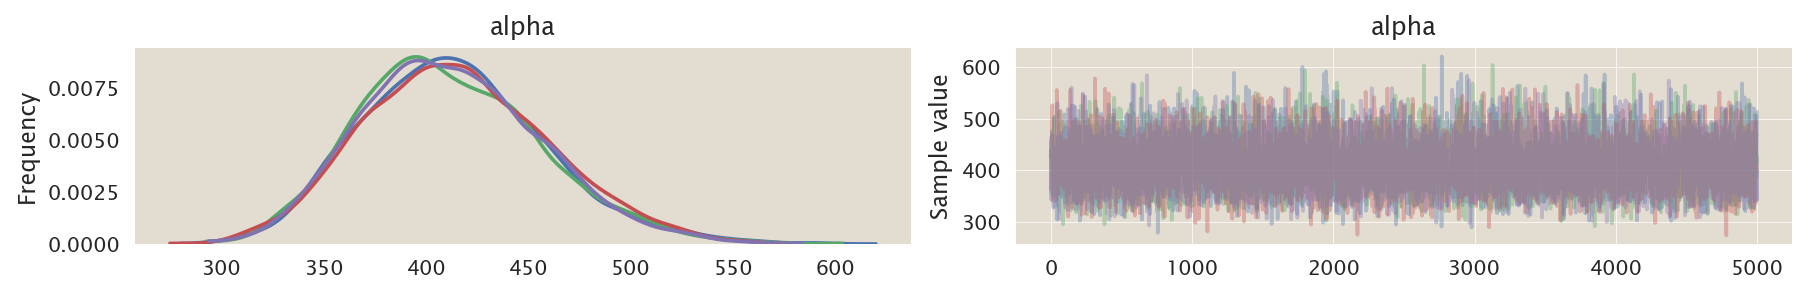

In [351]:
pm.traceplot(trace)

In [375]:
# Bin the data. 
bin_size =  50
brew_mean_sq_diff, brew_mean_I_tot = binning_mean(brewster_df, bin_width=bin_size, sort_values=True)

In [376]:
popt = scipy.optimize.minimize_scalar(deterministic_log_posterior, args=(I1, I2, I1 + I2, True))
popt

     fun: -inf
    nfev: 37
     nit: 36
 success: True
       x: 2.6180339603380443

In [373]:
len(I1 + I2)

1083

In [374]:
len(I1)

1083

In [371]:
deterministic_log_posterior?

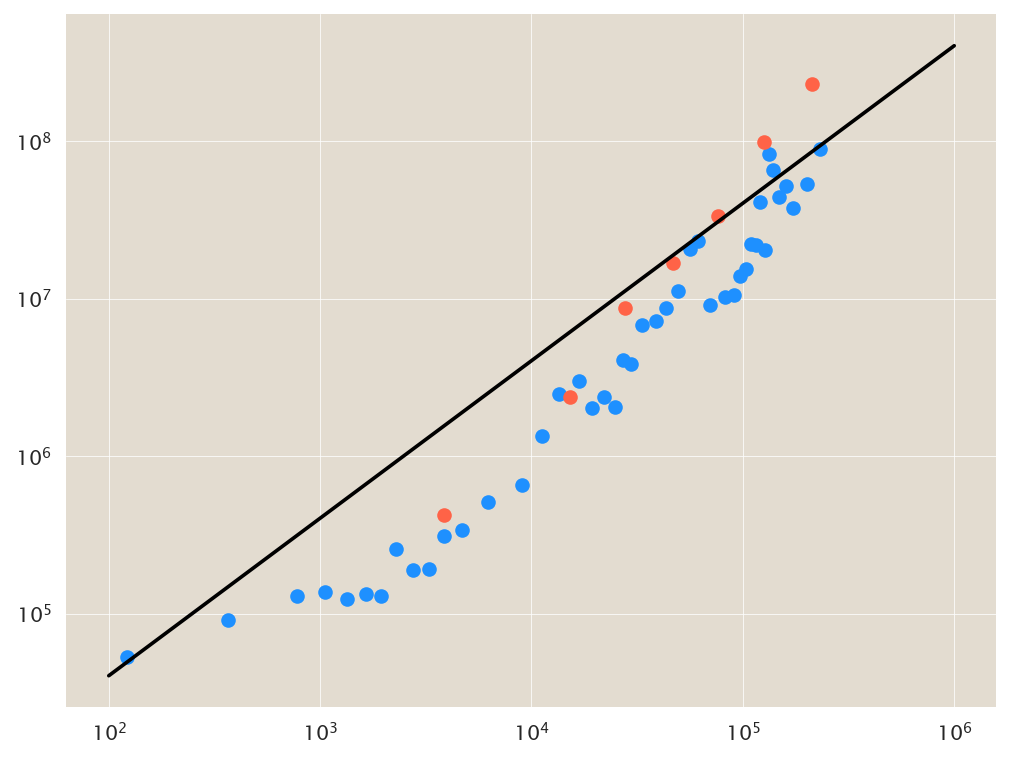

In [358]:
fig, ax = plt.subplots(1, 1)

ax.set_xscale('log')
ax.set_yscale('log')
# _ = ax.plot(brewster_df['I_tot'], (brewster_df['I_1'] - brewster_df['I_2'])**2, 'k.', alpha=0.5)
_ = ax.plot(brew_mean_I_tot, brew_mean_sq_diff, 'o', color='dodgerblue')
_ = ax.plot(mean_I_tot, mean_sq_diff, 'o', color='tomato')
_ = ax.plot(I_tot_range, alpha_opt * I_tot_range, 'k-')
# _ = ax.plot(I_1 + I_2, (I_1 - I_2)**2, '.', color='tomato', alpha=0.8)

In [344]:
# Subtract the autofluorescence from each channel.
snaps = growth_df[(growth_df['fluor2_measured'] == True) & (growth_df['fluor1_measured']==True)].copy()

# snaps.loc[:, 'fluor1_birth_sub'] = snaps['fluor1_birth_fluo'] - mean_auto_yfp * snaps['birth_area']
# snaps.loc[:, 'fluor2_birth_sub'] = snaps['fluor2_birth_fluo'] - mean_auto_cherry * snaps['birth_area']

# Group by position.
grouped = snaps.groupby(['position'])
mean_repressors = []
mean_yfp = []
position = []
for g, d in grouped:
    mch_expression = np.array([d.iloc[i]['fluor2'].max() for i in range(len(d))]) - mean_auto_cherry * d['birth_area'].values
    mean_repressors.append(np.mean(mch_expression) / alpha_opt)
    position.append(g)
    yfp_exp = []
    for i in range(len(d)):
        yfp_vals = np.array(d.iloc[i]['fluor1'])
        yfp_vals = yfp_vals[yfp_vals != 0]
        diff = np.diff(yfp_vals)
        mean_diff = np.mean(diff) 
        yfp_exp.append(mean_diff) 
        
#     yfp_exp = np.array([d.iloc[i]['fluor1'].max() for i in range(len(d))]) - mean_auto_yfp * d['birth_area'].values
#     yfp_exp = yfp_exp[yfp_exp != 0]
    yfp_exp = np.array(yfp_exp)
    exp = np.mean(yfp_exp[yfp_exp > 0])
    mean_yfp.append(exp)

int_df = pd.DataFrame(np.array([mean_repressors, mean_yfp, position]).T, columns=['mch', 'yfp', 'pos'])

/Users/gchure/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [345]:
snaps

,birth,death,divide,ID,motherID,sisterID,daughter_1_ID,daughter_2_ID,fluor1,fluor1_measured,birth_area,death_area,fluor2,fluor2_measured,position
36,1.0,12.0,1.0,14.0,0.0,0.0,59,60,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,266.0,495.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,7
37,5.0,17.0,1.0,28.0,4.0,27.0,91,92,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2189.0, 2331.0,...",True,248.0,527.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 28030.0, 0.0, 0.0, 0...",True,7
38,1.0,11.0,1.0,15.0,0.0,0.0,53,54,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,287.0,500.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,7
40,1.0,12.0,1.0,17.0,0.0,0.0,61,62,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,289.0,571.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,7
43,1.0,20.0,0.0,16.0,0.0,0.0,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,284.0,562.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,7
44,1.0,18.0,1.0,6.0,0.0,0.0,95,96,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,355.0,678.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,7
46,1.0,20.0,0.0,13.0,0.0,0.0,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,552.0,740.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,7
47,9.0,14.0,1.0,39.0,19.0,40.0,71,72,"[0.0, 0.0, 1975.0, 1924.0, 2222.0, 2329.0]",True,318.0,472.0,"[0.0, 27859.0, 0.0, 0.0, 0.0, 0.0]",True,7
48,1.0,17.0,1.0,5.0,0.0,0.0,89,90,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,325.0,656.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True,7
51,8.0,15.0,1.0,38.0,3.0,37.0,77,78,"[0.0, 0.0, 0.0, 1956.0, 1859.0, 2144.0, 2225.0...",True,280.0,442.0,"[0.0, 0.0, 28319.0, 0.0, 0.0, 0.0, 0.0, 0.0]",True,7


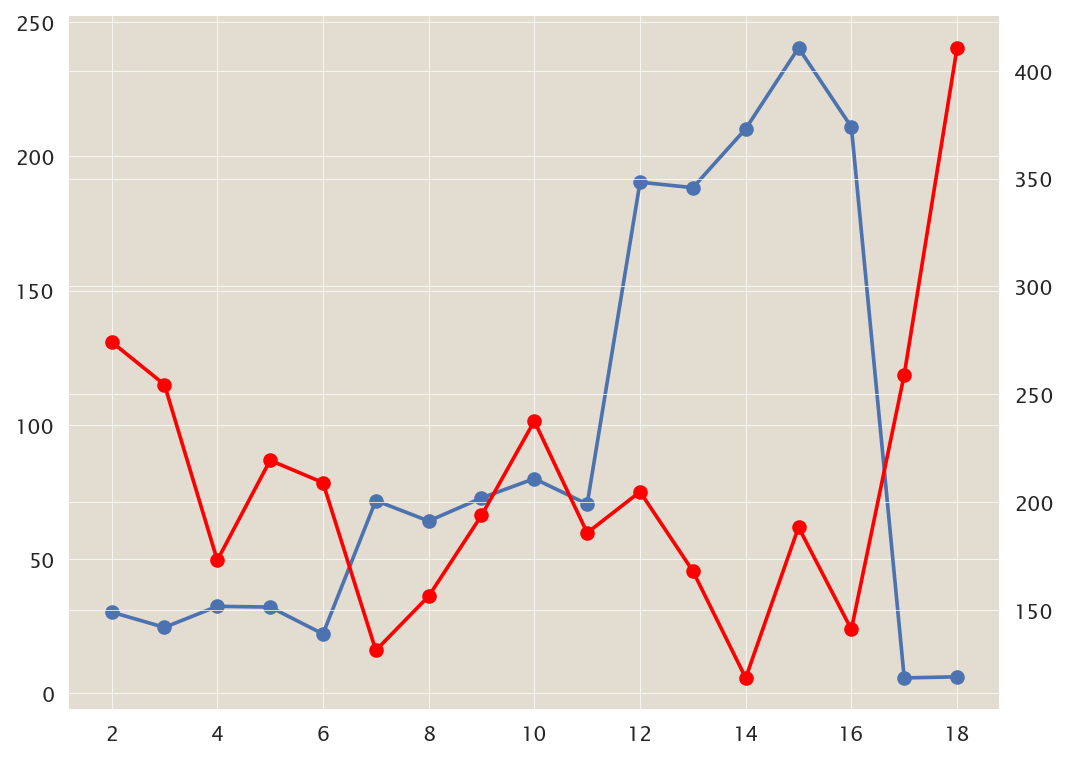

In [316]:
mch_grouped = int_df.groupby(['pos'])['mch'].mean()
yfp_grouped = int_df.groupby(['pos'])['yfp'].mean()
fig, ax = plt.subplots(1, 1)
ax.plot(mch_grouped, 'o-')
ax2 = ax.twinx()
ax2.plot(yfp_grouped, 'ro-')


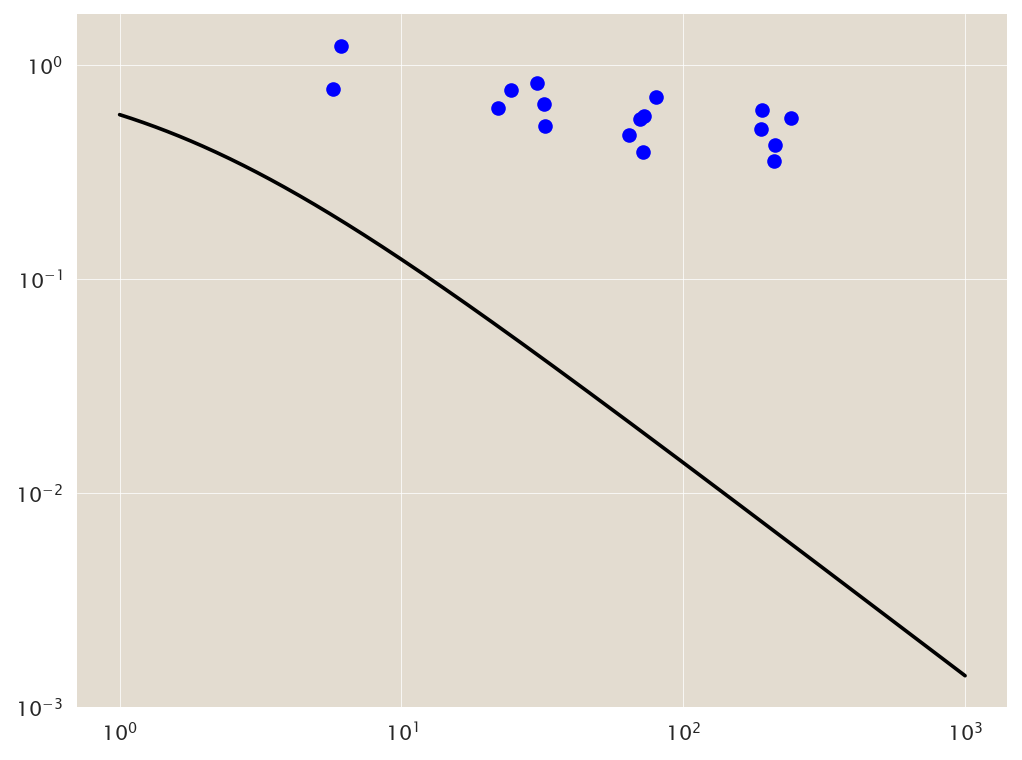

In [317]:
# Take a best guess for computing the fold-change.
delta = int_df[int_df['pos'] > 16]['yfp'].mean()
fc = int_df.groupby(['pos'])
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')

# Compute the theory.
rep_range = np.logspace(0, 3, 500)
theo = (1 + (rep_range / 4.6E6) * np.exp(15))**-1
ax.plot(rep_range, theo, 'k-')

for g, d in fc:
    ax.plot(d['mch'].mean(), d['yfp'].mean() / delta, 'bo')

pos
2.0     0.443997
3.0     0.364384
4.0     0.313258
5.0     0.818246
6.0     0.367888
7.0     0.251862
8.0     0.277614
9.0     0.347857
10.0    0.403576
11.0    0.369267
12.0    0.302740
13.0    0.249298
14.0    0.301463
15.0    0.279653
16.0    0.340329
17.0    0.926952
18.0    1.073048
Name: yfp, dtype: float64

In [284]:
grouped

pos
2.0     0.443997
3.0     0.364384
4.0     0.313258
5.0     0.818246
6.0     0.367888
7.0     0.251862
8.0     0.277614
9.0     0.347857
10.0    0.403576
11.0    0.369267
12.0    0.302740
13.0    0.249298
14.0    0.301463
15.0    0.279653
16.0    0.340329
17.0    0.926952
18.0    1.073048
Name: yfp, dtype: float64